# Estimation des émissions CO₂ d'une conférence en fonction de sa localisation

In [87]:
import csv
import geopy.distance
import matplotlib.pyplot as plt
import numpy as np
import unidecode

Lecture du nombre d'enseignants-chercheurs (MCF et PU) par académie. Pour chaque académie une seule ville a été retenue (Aix–Marseille ➡️ Marseille). La Corse, les DOMs et les personnels hors-académie ne sont pas pris en compte.

_Source de données : [“Note d'information DGRH relative aux personnels enseignants du supérieur pour l'année universitaire 2012-2013“](https://www.enseignementsup-recherche.gouv.fr/cid22654/demographie-desenseignants-de-l-enseignement-superieur.html)_

In [52]:
academies = {}
with open('academies.txt', 'r') as f:
    for line in f:
        if line[0] != '#':
            data = line.split()
            academies[data[0]] = int(data[1])

totacademies = sum(academies.values())
            
academies

{'Marseille': 3001,
 'Amiens': 1021,
 'Besançon': 967,
 'Bordeaux': 2765,
 'Caen': 1049,
 'Clermont-Ferrand': 1218,
 'Créteil': 2964,
 'Dijon': 974,
 'Grenoble': 2555,
 'Lille': 3665,
 'Limoges': 614,
 'Lyon': 3747,
 'Montpellier': 2255,
 'Metz': 2334,
 'Nantes': 2321,
 'Nice': 1331,
 'Orléans': 1609,
 'Paris': 8961,
 'Poitiers': 1306,
 'Reims': 946,
 'Rennes': 2685,
 'Rouen': 1262,
 'Strasbourg': 2090,
 'Toulouse': 3168,
 'Versailles': 3795}

Coordonnées (latitude et longitude) des grandes villes françaises

_Source : [FRENCH DATASET: POPULATION AND GPS COORDINATES](https://freakonometrics.hypotheses.org/1125)_

In [31]:
villes = {}
with open('villes.txt', 'r') as f:
    for line in f:
        if line[0] != '#':
            data = line.split('\t')
            villes[data[0]] = tuple(map(float, data[1:]))
villes['TOULOUSE']

(1.444209, 43.604652, 448859.6807)

In [42]:
def coord(acad):
    return villes[unidecode.unidecode(acad.upper())][0:2]

for k in academies.keys():
    coord(k)

coord('Besançon')

(6.0240539, 47.237829)

In [50]:
def distance(ac1, ac2):
    c1 = coord(ac1)
    c2 = coord(ac2)
    return geopy.distance.distance(c1, c2).km

print(distance('Lille', 'Marseille'))
print(distance('Paris', 'Versailles'))

853.2507748229115
25.31501549703571


In [59]:
def all_travel_to(center):
    sum = 0
    for acad in academies.keys():
        d = distance(center, acad)
        frac = float(academies[acad]) / totacademies
        sum += frac * d
    return sum

In [60]:
labels = sorted(academies.keys())
dist = [all_travel_to(acad) for acad in labels]

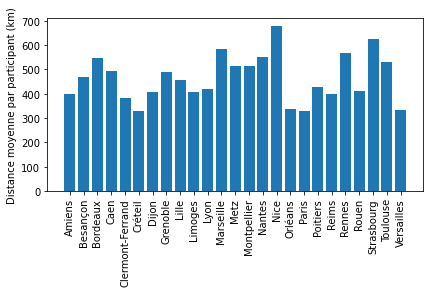

In [85]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.35, 0.87, 0.6])
ax.bar(labels, dist)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.ylabel('Distance moyenne par participant (km)')
#plt.show()
plt.savefig("distance.png", dpi=300)

## Calculs pour le train

In [128]:
with open('matrice_train.csv', 'r') as f:
    reader = csv.reader(f, delimiter=';')
    rows = [row for row in reader]
    trainlabels = rows[0][1:]
    
    traintime = dict()
    traintime_arr = np.zeros((len(trainlabels), len(trainlabels)), np.int)
    for irow, row in enumerate(rows[1:]):
        traintime[(trainlabels[irow], trainlabels[irow])] = 0
        for icol, cell in enumerate(row[1:]):
            if len(cell) > 0:
                traintime[(trainlabels[irow], trainlabels[icol])] = int(cell)
                traintime[(trainlabels[icol], trainlabels[irow])] = int(cell)
                traintime_arr[icol,irow] = int(cell)
                traintime_arr[irow,icol] = int(cell)

In [129]:
traintime[('Lyon', 'Bordeaux')]/60

4.866666666666666

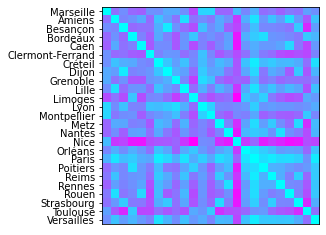

In [130]:
fig, ax = plt.subplots()
ax.imshow(traintime_arr, cmap='cool', interpolation='nearest')
ax.set_xticks([])
ax.set_yticks(np.arange(len(trainlabels)))
ax.set_yticklabels(trainlabels)
plt.show()

In [131]:
def all_train_to(center):
    sum = 0
    for acad in academies.keys():
        d = traintime[(center, acad)]
        frac = float(academies[acad]) / totacademies
        sum += frac * d
    return sum

In [132]:
labels = sorted(academies.keys())
dist = [all_train_to(acad) for acad in labels]

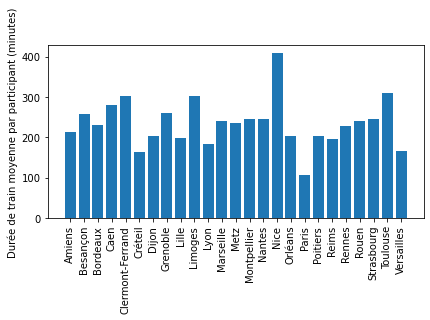

In [133]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.35, 0.87, 0.6])
ax.bar(labels, dist)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.ylabel('Durée de train moyenne par participant (minutes)')
#plt.show()
plt.savefig("distance.png", dpi=300)